<a href="https://colab.research.google.com/github/hilmirasyid-dev/UAS-Big-Data-Predictive-Analytics-Lanjut/blob/main/23_11_5918_UAS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
base = '/content/drive/MyDrive/Project/Hilmimabur/'
dataset = f"{base}/diamonds.csv"

In [ ]:
# nyalakan spark session
from pyspark.sql import SparkSession
from pyspark.sql.functions import col,sum

# buat sesi
spark = SparkSession.builder.appName("UAS_BDPAL").master('local[*]').getOrCreate()
print("sprak session ready to cooking, version:", spark.version)

sprak session ready to cooking, version: 4.0.1


In [ ]:
# load dataset
import pandas as pd
df_raw = spark.read.csv(dataset, header=True, inferSchema=True)
df_raw.show(5, truncate=False)

# ubah paksa ke parquet
df_raw.write.mode('overwrite').parquet(f"{base}/diamonds.parquet")


+---+-----+-------+-----+-------+-----+-----+-----+----+----+----+
|_c0|carat|cut    |color|clarity|depth|table|price|x   |y   |z   |
+---+-----+-------+-----+-------+-----+-----+-----+----+----+----+
|1  |0.23 |Ideal  |E    |SI2    |61.5 |55.0 |326  |3.95|3.98|2.43|
|2  |0.21 |Premium|E    |SI1    |59.8 |61.0 |326  |3.89|3.84|2.31|
|3  |0.23 |Good   |E    |VS1    |56.9 |65.0 |327  |4.05|4.07|2.31|
|4  |0.29 |Premium|I    |VS2    |62.4 |58.0 |334  |4.2 |4.23|2.63|
|5  |0.31 |Good   |J    |SI2    |63.3 |58.0 |335  |4.34|4.35|2.75|
+---+-----+-------+-----+-------+-----+-----+-----+----+----+----+
only showing top 5 rows


3.a. Pemrosesan Batch dengan MapReduce

In [ ]:
# make df yang udah jadi parquet
df = spark.read.parquet(f"{base}/diamonds.parquet")
df.show(5, truncate=False)

+---+-----+-------+-----+-------+-----+-----+-----+----+----+----+
|_c0|carat|cut    |color|clarity|depth|table|price|x   |y   |z   |
+---+-----+-------+-----+-------+-----+-----+-----+----+----+----+
|1  |0.23 |Ideal  |E    |SI2    |61.5 |55.0 |326  |3.95|3.98|2.43|
|2  |0.21 |Premium|E    |SI1    |59.8 |61.0 |326  |3.89|3.84|2.31|
|3  |0.23 |Good   |E    |VS1    |56.9 |65.0 |327  |4.05|4.07|2.31|
|4  |0.29 |Premium|I    |VS2    |62.4 |58.0 |334  |4.2 |4.23|2.63|
|5  |0.31 |Good   |J    |SI2    |63.3 |58.0 |335  |4.34|4.35|2.75|
+---+-----+-------+-----+-------+-----+-----+-----+----+----+----+
only showing top 5 rows


In [ ]:
##Mapreduce
# hitung jumlah yang unik di kolom cut
print('jumlah yang unik di cut :', df.select("cut").distinct().count())

# MapReduce untuk menghitung jumlah per 'cut'
rdd_cut = df.rdd.map(lambda x: (x['cut'], 1))
count_by_cut = rdd_cut.reduceByKey(lambda a, b: a + b)

# tampilkan data dri rdd
count_by_cut.take(10)


jumlah yang unik di cut : 5


[('Ideal', 21551),
 ('Premium', 13791),
 ('Good', 4906),
 ('Very Good', 12082),
 ('Fair', 1610)]

In [ ]:
## mapreduce
# hitung jumlah yang unik di kolom cut
print('jumlah yang unik di color :', df.select("color").distinct().count()
)

rdd_price = df.rdd.map(lambda x: (x['color'], x['price']))
total_price_by_color = rdd_price.reduceByKey(lambda a, b: a + b)

#tampilkan hasil
total_price_by_color.take(10)

jumlah yang unik di color : 7


[('E', 30142944),
 ('I', 27608146),
 ('J', 14949281),
 ('H', 37257301),
 ('F', 35542866),
 ('G', 45158240),
 ('D', 21476439)]

#3.b. Exploratory Data Analysis (EDA) & Visualisasi

In [ ]:
df.describe().show()

+-------+------------------+------------------+---------+-----+-------+------------------+------------------+-----------------+------------------+------------------+------------------+
|summary|               _c0|             carat|      cut|color|clarity|             depth|             table|            price|                 x|                 y|                 z|
+-------+------------------+------------------+---------+-----+-------+------------------+------------------+-----------------+------------------+------------------+------------------+
|  count|             53940|             53940|    53940|53940|  53940|             53940|             53940|            53940|             53940|             53940|             53940|
|   mean|           26970.5|0.7979397478679852|     NULL| NULL|   NULL| 61.74940489432624| 57.45718390804603|3932.799721913237| 5.731157211716609| 5.734525954764462|3.5387337782723316|
| stddev|15571.281096942537|0.4740112444054196|     NULL| NULL|   NULL|1.43

In [ ]:
df.printSchema()

root
 |-- _c0: integer (nullable = true)
 |-- carat: double (nullable = true)
 |-- cut: string (nullable = true)
 |-- color: string (nullable = true)
 |-- clarity: string (nullable = true)
 |-- depth: double (nullable = true)
 |-- table: double (nullable = true)
 |-- price: integer (nullable = true)
 |-- x: double (nullable = true)
 |-- y: double (nullable = true)
 |-- z: double (nullable = true)



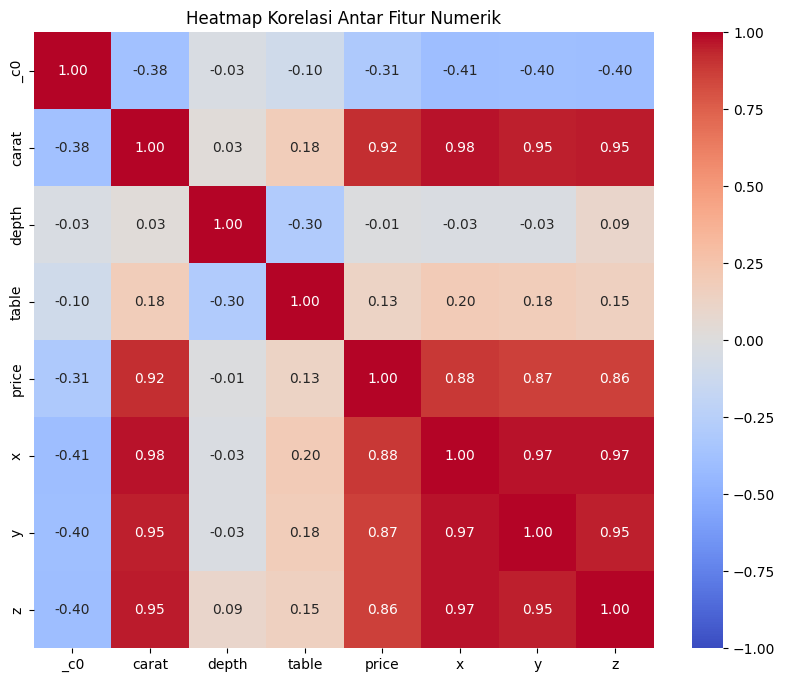

In [ ]:
# print korelasi between 'carat' and 'price'
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from pyspark.sql.types import DoubleType, IntegerType, LongType

# Get numeric columns from the PySpark DataFrame
numeric_cols = [field.name for field in df.schema.fields if isinstance(field.dataType, (DoubleType, IntegerType, LongType))]

# Calculate pairwise correlations
corr_data = []
for i, col1 in enumerate(numeric_cols):
    row = []
    for j, col2 in enumerate(numeric_cols):
        if i <= j: # Avoid duplicate calculations and self-correlation (or calculate once)
            correlation = df.corr(col1, col2)
            row.append(correlation)
        else:
            # For the lower triangle, you can append None or calculate again
            # For symmetry, we'll append the already calculated value from the upper triangle
            row.append(corr_data[j][i]) # This assumes corr_data is built row by row
    corr_data.append(row)

# Convert to Pandas DataFrame for Seaborn
# A more robust way to build the correlation matrix for a square symmetric matrix
corr_matrix = pd.DataFrame(index=numeric_cols, columns=numeric_cols)
for col1 in numeric_cols:
    for col2 in numeric_cols:
        corr_matrix.loc[col1, col2] = df.corr(col1, col2)

# Convert all values to float (they might be returned as strings or other types by PySpark's corr if null)
corr_matrix = corr_matrix.astype(float)

# Tampilkan heatmap korelasi
plt.figure(figsize=(10, 8)) # Adjusted figure size for better readability
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, fmt=".2f")
plt.title('Heatmap Korelasi Antar Fitur Numerik')
plt.show()

In [ ]:
# Contoh 1: Casting tipe data
df_clean = df.withColumn("carat", col("carat").cast("double")) \
             .withColumn("price", col("price").cast("int"))

# Contoh 2: Menghapus baris yang memiliki nilai null di kolom penting
df_clean = df_clean.na.drop(subset=["carat", "cut", "price"])


In [ ]:
# membuang _c0
df_clean = df_clean.drop('_c0')
df_clean.show(5)

+-----+-------+-----+-------+-----+-----+-----+----+----+----+
|carat|    cut|color|clarity|depth|table|price|   x|   y|   z|
+-----+-------+-----+-------+-----+-----+-----+----+----+----+
| 0.23|  Ideal|    E|    SI2| 61.5| 55.0|  326|3.95|3.98|2.43|
| 0.21|Premium|    E|    SI1| 59.8| 61.0|  326|3.89|3.84|2.31|
| 0.23|   Good|    E|    VS1| 56.9| 65.0|  327|4.05|4.07|2.31|
| 0.29|Premium|    I|    VS2| 62.4| 58.0|  334| 4.2|4.23|2.63|
| 0.31|   Good|    J|    SI2| 63.3| 58.0|  335|4.34|4.35|2.75|
+-----+-------+-----+-------+-----+-----+-----+----+----+----+
only showing top 5 rows


3.d. Manipulasi Data (Spark SQL & Aggregation)

In [ ]:
df_clean.createOrReplaceTempView("diamonds_table")
## Spark SQL dengan CTE
query_cte = """
WITH avg_price_table AS (
    SELECT AVG(price) as rerata FROM diamonds_table
)
SELECT * FROM diamonds_table, avg_price_table WHERE price > rerata
"""
# jumlah data yang di atas rata2
print('Jumlah data diatas rata2:',spark.sql(query_cte).count())

spark.sql(query_cte).show(5)

Jumlah data diatas rata2: 19657
+-----+---------+-----+-------+-----+-----+-----+----+----+----+-----------------+
|carat|      cut|color|clarity|depth|table|price|   x|   y|   z|           rerata|
+-----+---------+-----+-------+-----+-----+-----+----+----+----+-----------------+
|  0.9|  Premium|    H|    VS2| 62.6| 58.0| 3933|6.14|6.19|3.86|3932.799721913237|
| 0.93|Very Good|    G|    SI1| 62.5| 57.8| 3933|6.15|6.28|3.87|3932.799721913237|
| 0.83|    Ideal|    D|    SI1| 61.5| 53.0| 3933|6.09|6.07|3.74|3932.799721913237|
|  0.9|     Good|    E|    SI1| 60.8| 65.0| 3933|6.14|6.17|3.74|3932.799721913237|
| 0.81|    Ideal|    F|    VS1| 61.5| 55.0| 3933|6.01|5.96|3.68|3932.799721913237|
+-----+---------+-----+-------+-----+-----+-----+----+----+----+-----------------+
only showing top 5 rows


In [ ]:
#Grouping & Aggregation
df_clean.groupBy("clarity").avg("price").orderBy("avg(price)", ascending=False).show()

+-------+------------------+
|clarity|        avg(price)|
+-------+------------------+
|    SI2| 5063.028605612356|
|    SI1| 3996.001148105626|
|    VS2| 3924.989394681025|
|     I1|3924.1686909581645|
|    VS1|3839.4553910170116|
|   VVS2| 3283.737070667193|
|     IF| 2864.839106145251|
|   VVS1|   2523.1146374829|
+-------+------------------+



3.e. Operasi Partisi Menggunakan RDD

In [ ]:
#FlatMap (Transformasi baris menjadi list elemen)
rdd_flat = df_clean.rdd.flatMap(lambda x: [x['cut'], x['color']])

#tampilkan
rdd_flat.take(10)

['Ideal', 'E', 'Premium', 'E', 'Good', 'E', 'Premium', 'I', 'Good', 'J']

In [ ]:
#GroupByKey dan Re-partitioning
rdd_grouped = df.rdd.map(lambda x: (x['cut'], x)) \
                    .partitionBy(5) \
                    .groupByKey()
rdd_grouped.take(5)

[('Fair', <pyspark.resultiterable.ResultIterable at 0x7e6c9ed8deb0>),
 ('Premium', <pyspark.resultiterable.ResultIterable at 0x7e6c9ed8df40>),
 ('Very Good', <pyspark.resultiterable.ResultIterable at 0x7e6c9c5fed50>),
 ('Ideal', <pyspark.resultiterable.ResultIterable at 0x7e6c9efd0050>),
 ('Good', <pyspark.resultiterable.ResultIterable at 0x7e6c9f264050>)]

4.Permodelan Algoritma ML Framework (MLLib)

In [ ]:
#Feature Engineering: Tambah Volume
df_robust = df_clean.withColumn("volume", col("x") * col("y") * col("z"))

# ambil 20% data dari dataset untuk sampling mana model yang terbaik
# sebelum melakukan full training
df_robust_sample = df_robust.sample(False, 0.20, seed=42)

In [ ]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, VectorAssembler

# 2. Encoding Kategorikal (Ordinal Encoding)
indexers = [
    StringIndexer(inputCol=c, outputCol=f"{c}_indexed")
    for c in ["cut", "color", "clarity"]
]

# 3. Menggabungkan Fitur ke dalam satu Vektor
feature_cols = ["carat", "depth", "table", "x", "y", "z", "volume",
                "cut_indexed", "color_indexed", "clarity_indexed"]
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")

In [ ]:
# Split Data untuk sample milih antara 2 model
train_data, test_data = df_robust_sample.randomSplit([0.8, 0.2], seed=42)

In [ ]:
# training sampe mateng
from pyspark.ml.regression import RandomForestRegressor, GBTRegressor

# Model 1: Random Forest
rf = RandomForestRegressor(featuresCol="features", labelCol="price", numTrees=50)

# Model 2: GBT (Gradient Boosted Trees)
gbt = GBTRegressor(featuresCol="features", labelCol="price", maxIter=20)

# Masukkan ke dalam Pipeline
pipeline_rf = Pipeline(stages=indexers + [assembler, rf])
pipeline_gbt = Pipeline(stages=indexers + [assembler, gbt])

# Training
model_rf = pipeline_rf.fit(train_data)
model_gbt = pipeline_gbt.fit(train_data)

In [ ]:
from pyspark.ml.evaluation import RegressionEvaluator

# Ambil Prediksi untuk prediksi test data
predictions_gbt = model_gbt.transform(test_data)
predictions_rf = model_rf.transform(test_data)

# List metrik
metrics = ["rmse", "mse", "mae", "r2"]

print("=== HASIL EVALUASI data sample model GBT vs RF ===")

# Perulangan untuk menghitung dan menampilkan setiap metrik
for m in metrics:
    evaluator = RegressionEvaluator(labelCol="price", predictionCol="prediction", metricName=m)
    score_gbt = evaluator.evaluate(predictions_gbt)
    score_rf = evaluator.evaluate(predictions_rf)

    print(f"{m.upper():<5}: {score_gbt:.4f} VS {score_rf:.4f}")

print("========================================")

=== HASIL EVALUASI data sample model GBT vs RF ===
RMSE : 825.3568 VS 1090.2866
MSE  : 681213.7665 VS 1188724.8362
MAE  : 444.4212 VS 588.1052
R2   : 0.9570 VS 0.9249


5 Hyperparameter Tuning (Best Model: GBT)

In [ ]:
# pakai splitan dari data asli
train_data_real, test_data_real = df_robust.randomSplit([0.8, 0.2], seed=42)

In [ ]:
from pyspark.ml.tuning import ParamGridBuilder, TrainValidationSplit

# Grid Parameter
paramGrid = ParamGridBuilder() \
    .addGrid(gbt.maxDepth, [5, 10]) \
    .addGrid(gbt.maxIter, [20, 50]) \
    .build()

# Definisikan Evaluator (fokus pada RMSE)
evaluator_rmse = RegressionEvaluator(labelCol="price", predictionCol="prediction", metricName="rmse")

# Setup Hyperparameter Tuning
tvs = TrainValidationSplit(
    estimator=pipeline_gbt,
    estimatorParamMaps=paramGrid,
    evaluator=evaluator_rmse,

    # 80% data untuk training, 20% untuk validasi tuning
    trainRatio=0.8
)

# Run Tuning
print("Sedang melakukan Hyperparameter Tuning... Harap tunggu.")
model_final_gbt = tvs.fit(train_data_real)
print('Selesai')

Sedang melakukan Hyperparameter Tuning... Harap tunggu.
Selesai


In [ ]:
from pyspark.ml.evaluation import RegressionEvaluator

# Ambil Prediksi dari Best Model untuk prediksi testdatafinal
predictions_final = model_final_gbt.transform(test_data_real)

# List metrik
metrics = ["rmse", "mse", "mae", "r2"]

print("=== HASIL EVALUASI AKHIR (BEST MODEL GBT) ===")

# Perulangan untuk menghitung dan menampilkan setiap metrik
for m in metrics:
    evaluator = RegressionEvaluator(labelCol="price", predictionCol="prediction", metricName=m)
    score = evaluator.evaluate(predictions_final)
    print(f"{m.upper():<5}: {score:.4f}")

print("==============================================")

=== HASIL EVALUASI AKHIR (BEST MODEL GBT) ===
RMSE : 629.6752
MSE  : 396490.9203
MAE  : 345.5663
R2   : 0.9756


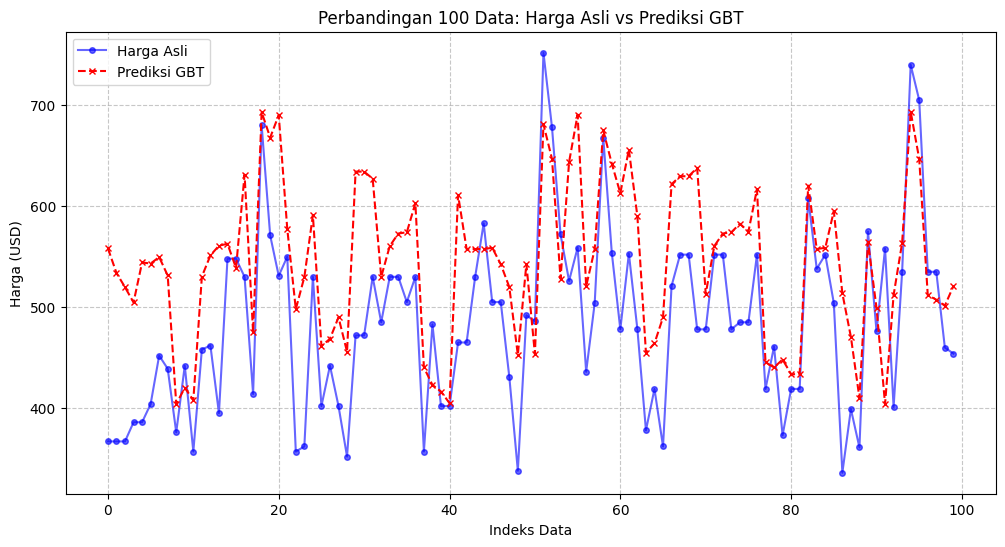

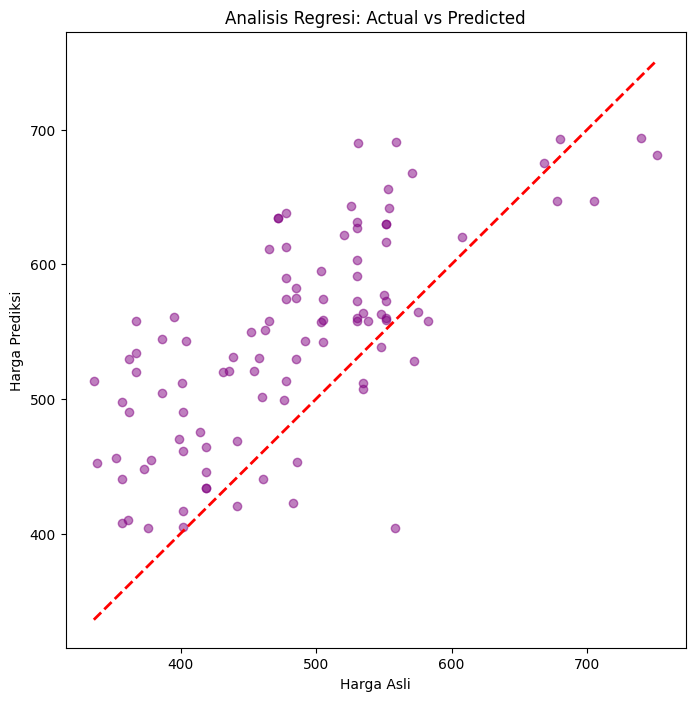

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# 1. Ambil 100 sampel dari hasil prediksi
sample_result = predictions_final.select("price", "prediction").limit(100).toPandas()

# 2. Plotting
plt.figure(figsize=(12, 6))

# Garis Harga Asli (Actual)
plt.plot(sample_result.index, sample_result['price'], color='blue', label='Harga Asli', marker='o', markersize=4, linestyle='-', alpha=0.6)

# Garis Harga Prediksi (Predicted)
plt.plot(sample_result.index, sample_result['prediction'], color='red', label='Prediksi GBT', marker='x', markersize=4, linestyle='--')

plt.title('Perbandingan 100 Data: Harga Asli vs Prediksi GBT')
plt.xlabel('Indeks Data')
plt.ylabel('Harga (USD)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

# 3. Scatter Plot untuk melihat korelasi (Opsional tapi bagus untuk ujian)
plt.figure(figsize=(8, 8))
plt.scatter(sample_result['price'], sample_result['prediction'], alpha=0.5, color='purple')
plt.plot([sample_result['price'].min(), sample_result['price'].max()],
         [sample_result['price'].min(), sample_result['price'].max()],
         'r--', lw=2) # Garis diagonal sempurna
plt.title('Analisis Regresi: Actual vs Predicted')
plt.xlabel('Harga Asli')
plt.ylabel('Harga Prediksi')
plt.show()

Kesimpulan Akhir:Melalui implementasi pipeline Big Data menggunakan PySpark, model Gradient Boosted Trees (GBT) terpilih sebagai model terbaik untuk estimasi harga berlian.

 1. Efektivitas Tuning: Proses Hyperparameter Tuning terbukti krusial, di mana model final berhasil mencapai nilai $R^2$ sebesar 0.9756, yang berarti model mampu menjelaskan lebih dari 97% variabilitas harga.

 2. Akurasi Operasional: Dengan nilai MAE sebesar 345.56, model ini memiliki tingkat kesalahan rata-rata yang relatif rendah untuk industri barang mewah, menjadikannya alat yang sangat berguna untuk estimasi harga otomatis (Automated Valuation Model).

 3. Kekuatan Model: Visualisasi 100 data menunjukkan bahwa model sangat robust dalam menangkap volatilitas harga, meskipun terdapat sedikit kecenderungan overestimation pada rentang harga rendah yang dapat dioptimalkan lebih lanjut di masa depan dengan penambahan fitur atau pembersihan outlier yang lebih ketat.